In [2407]:
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

PATH = os.path.join("datasets", "ps6")

# Fetch csv files conatining the training, validation, and testing data
def load_weather_data(file, data_path=PATH):
    os.makedirs(data_path, exist_ok=True)
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path)

In [2408]:
# Import needed tools to conduct time-series analysis
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2409]:
# Load csv file and investigate the data, dropping first row since values are all null
weather_train = load_weather_data("ps6_trainvalid.csv")
weather_test = load_weather_data("ps6_test.csv")
weather_train = weather_train.dropna(subset=["weather"])
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45012 entries, 1 to 45012
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime        45012 non-null  object 
 1   temperature     45010 non-null  float64
 2   humidity        44861 non-null  float64
 3   pressure        44761 non-null  float64
 4   weather         45012 non-null  object 
 5   wind_direction  45012 non-null  float64
 6   wind_speed      45012 non-null  float64
dtypes: float64(5), object(2)
memory usage: 2.7+ MB


In [2410]:
# Set the datetime variables for training and testing data and remove from DataFrame
date_time = pd.to_datetime(weather_train.pop('datetime'))
date_time_test = pd.to_datetime(weather_test.pop('datetime'))

weather_train.head()

,temperature,humidity,pressure,weather,wind_direction,wind_speed
1,291.870000,88.0,1013.0,mist,0.0,0.0
2,291.868186,88.0,1013.0,sky is clear,0.0,0.0
3,291.862844,88.0,1013.0,sky is clear,0.0,0.0
4,291.857503,88.0,1013.0,sky is clear,0.0,0.0
5,291.852162,88.0,1013.0,sky is clear,0.0,0.0


In [2411]:
# For each numerical value, compute the mean and use it as a fill-in for missing data
temp_mean = weather_train["temperature"].mean()
weather_train["temperature"].fillna(temp_mean, inplace=True)

humid_mean = weather_train["humidity"].mean()
weather_train["humidity"].fillna(humid_mean, inplace=True)

pressure_mean = weather_train["pressure"].mean()
weather_train["pressure"].fillna(pressure_mean, inplace=True)

wind_speed_mean = weather_train["wind_speed"].mean()
weather_train["wind_speed"].fillna(wind_speed_mean, inplace=True)

wind_direction_mean = weather_train["wind_direction"].mean()
weather_train["wind_direction"].fillna(wind_direction_mean, inplace=True)

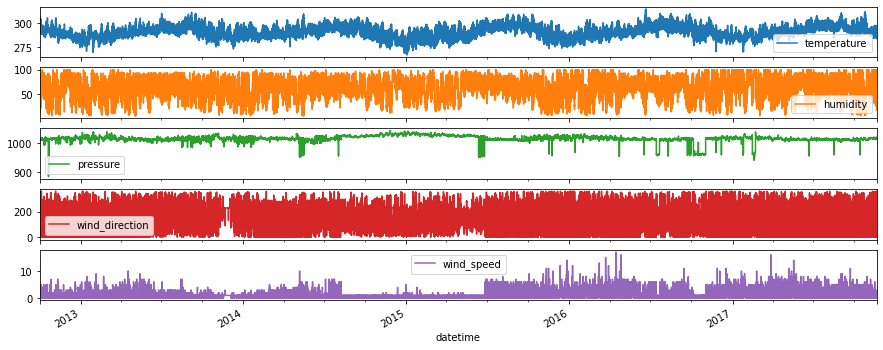

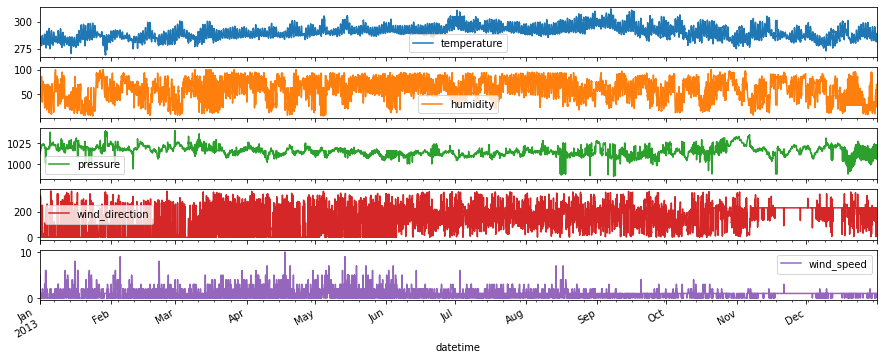

In [2412]:
# Two visuals showing trends in the data, one spanning the entire set and another just one year
plot_cols = ['temperature', 'humidity', 'pressure',  'wind_direction', 'wind_speed']
plot_features = weather_train[plot_cols][:]
plot_features.index = date_time[:]
_ = plot_features.plot(subplots=True, figsize=(15,6))

plot_features = weather_train[plot_cols][2190:10950]
plot_features.index = date_time[2190:10950]
_ = plot_features.plot(subplots=True, figsize=(15,6))

In [2413]:
# Ensure all data is present and not null
weather_train.info()
weather_train.describe().transpose()
weather_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45012 entries, 1 to 45012
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temperature     45012 non-null  float64
 1   humidity        45012 non-null  float64
 2   pressure        45012 non-null  float64
 3   weather         45012 non-null  object 
 4   wind_direction  45012 non-null  float64
 5   wind_speed      45012 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.4+ MB


,temperature,humidity,pressure,weather,wind_direction,wind_speed
1,291.870000,88.0,1013.0,mist,0.0,0.0
2,291.868186,88.0,1013.0,sky is clear,0.0,0.0
3,291.862844,88.0,1013.0,sky is clear,0.0,0.0
4,291.857503,88.0,1013.0,sky is clear,0.0,0.0
5,291.852162,88.0,1013.0,sky is clear,0.0,0.0


Text(0, 0.5, 'Wind Velocity')

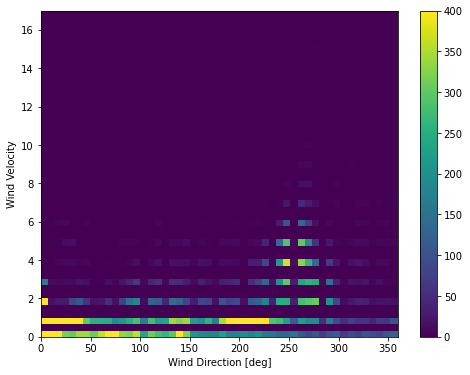

In [2414]:
# Plot showing the current distribution of wind direction data
plt.hist2d(weather_train['wind_direction'], weather_train['wind_speed'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity')

In [2415]:
# Turn wind into a vector of speed and direction rather than separate components
wv = weather_train.pop('wind_speed')
wv_test = weather_test.pop('wind_speed')

# Convert degrees to radians--0 and 360 should be next to each other not far apart
wind_direction_rad = weather_train.pop('wind_direction')*np.pi / 180
wind_direction_rad_test = weather_test.pop('wind_direction')*np.pi / 180

# Calculate the wind x and y components
weather_train['wind_speed_x'] = wv*np.cos(wind_direction_rad)
weather_train['wind_speed_y'] = wv*np.sin(wind_direction_rad)

weather_test['wind_speed_x'] = wv_test*np.cos(wind_direction_rad_test)
weather_test['wind_speed_y'] = wv_test*np.sin(wind_direction_rad_test)

(-11.0, 13.0, -15.974774553360445, 10.724622203665692)

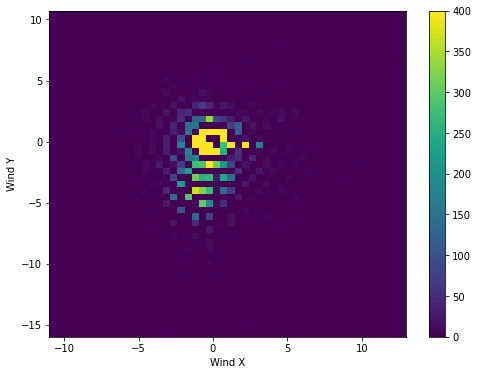

In [2416]:
# New distribution of wind that is easier for the model to interpret
plt.hist2d(weather_train['wind_speed_x'], weather_train['wind_speed_y'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X')
plt.ylabel('Wind Y')
ax = plt.gca()
ax.axis('tight')

In [2417]:
timestamp_s = date_time.map(datetime.datetime.timestamp)
timestamp_s_test = date_time_test.map(datetime.datetime.timestamp)

In [2418]:
# Use the yearly and daily seasonality of temperature to improve model
day = 24*60*60
year = (365.2425)*day

time_array = timestamp_s * (2 * np.pi / day)

# Add a sin and cosine column to weather data for both the day and the year
weather_train['day_sin'] = np.sin(time_array)
weather_train['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
weather_train['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
weather_train['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

weather_test['day_sin'] = np.sin(timestamp_s_test * (2 * np.pi / day))
weather_test['day_cos'] = np.cos(timestamp_s_test * (2 * np.pi / day))
weather_test['year_sin'] = np.sin(timestamp_s_test * (2 * np.pi / year))
weather_test['year_cos'] = np.cos(timestamp_s_test * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

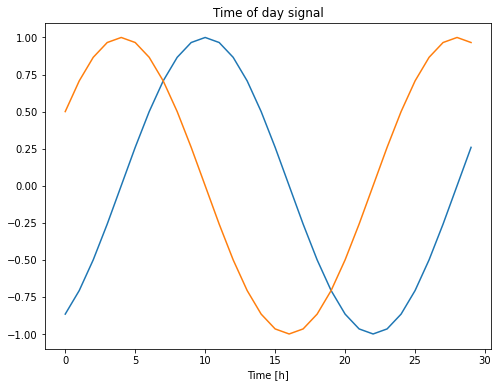

In [2419]:
plt.plot(np.array(weather_train['day_sin'])[:30])
plt.plot(np.array(weather_train['day_cos'])[:30])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

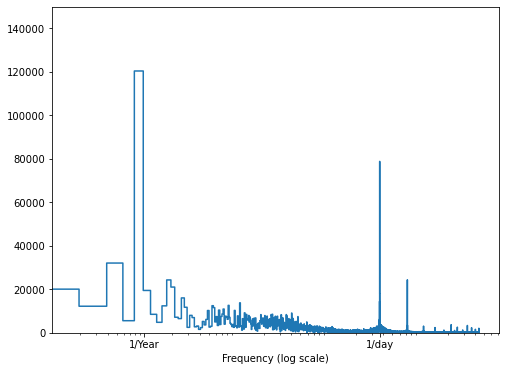

In [2420]:
# Graph showing the most important frequency features are years and days to confirm steps above
fft = tf.signal.rfft(weather_train['temperature'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(weather_train['temperature'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 150000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [2421]:
from sklearn.preprocessing import OrdinalEncoder

# Must encode the categorical data in order to use it in our model
ordinal_encoder = OrdinalEncoder()

weather_condition = weather_train[["weather"]]
weather_condition_test = weather_test[["weather"]]

weather_encoded = ordinal_encoder.fit_transform(weather_condition)
test_weather_encoded = ordinal_encoder.fit_transform(weather_condition_test)

weather_test['weather'] = test_weather_encoded
weather_train['weather'] = weather_encoded
test_weather_encoded[:10]

array([[9.],
       [6.],
       [9.],
       [9.],
       [9.],
       [9.],
       [9.],
       [9.],
       [9.],
       [4.]])

In [2422]:
weather_train

,temperature,humidity,pressure,weather,wind_speed_x,wind_speed_y,day_sin,day_cos,year_sin,year_cos
1,291.870000,88.0,1013.0,10.0,0.000000,0.000000,-8.660254e-01,5.000000e-01,-0.999924,0.012325
2,291.868186,88.0,1013.0,17.0,0.000000,0.000000,-7.071068e-01,7.071068e-01,-0.999915,0.013041
3,291.862844,88.0,1013.0,17.0,0.000000,0.000000,-5.000000e-01,8.660254e-01,-0.999905,0.013758
4,291.857503,88.0,1013.0,17.0,0.000000,0.000000,-2.588190e-01,9.659258e-01,-0.999895,0.014475
5,291.852162,88.0,1013.0,17.0,0.000000,0.000000,-6.304366e-12,1.000000e+00,-0.999885,0.015192
...,...,...,...,...,...,...,...,...,...,...
45008,295.440000,17.0,1017.0,17.0,0.965926,-0.258819,8.660254e-01,5.000000e-01,-0.654451,0.756104
45009,296.020000,16.0,1016.0,17.0,0.965926,-0.258819,9.659258e-01,2.588190e-01,-0.653909,0.756573
45010,296.510000,17.0,1015.0,17.0,0.965926,-0.258819,1.000000e+00,1.086883e-11,-0.653367,0.757042
45011,297.090000,17.0,1014.0,17.0,0.000000,-0.000000,9.659258e-01,-2.588190e-01,-0.652824,0.757510


In [2423]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

# Fit the training data with a Ridge model to determine feature importance
X_train, X_val, y_train, y_val = train_test_split(
    weather_train.drop(["temperature"], axis=1), weather_train["temperature"], random_state=0)

model = Ridge(alpha=1e-2).fit(X_train, y_train)
model.score(X_val, y_val)

0.7056595255834961

In [2424]:
weather_train
headers = list(weather_train.drop(["temperature"], axis=1))

In [2425]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0)

# For loop outputting the features that are most relevant and a margin of error
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{headers[i]:<8}    "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

year_cos    0.599 +/- 0.007
day_sin     0.298 +/- 0.006
humidity    0.151 +/- 0.004
year_sin    0.138 +/- 0.004
pressure    0.008 +/- 0.001
wind_speed_y    0.007 +/- 0.001
weather     0.003 +/- 0.000
wind_speed_x    0.003 +/- 0.000
day_cos     0.002 +/- 0.000


In [2426]:
# From above we can see which features have the least significance
# From later model testing, these were the features dropped 
weather_train = weather_train.drop(["wind_speed_y", "wind_speed_x", "weather", "day_cos", "pressure"], axis=1)
weather_test = weather_test.drop(["wind_speed_y", "wind_speed_x", "weather", "day_cos", "pressure"], axis=1)
weather_train

,temperature,humidity,day_sin,year_sin,year_cos
1,291.870000,88.0,-8.660254e-01,-0.999924,0.012325
2,291.868186,88.0,-7.071068e-01,-0.999915,0.013041
3,291.862844,88.0,-5.000000e-01,-0.999905,0.013758
4,291.857503,88.0,-2.588190e-01,-0.999895,0.014475
5,291.852162,88.0,-6.304366e-12,-0.999885,0.015192
...,...,...,...,...,...
45008,295.440000,17.0,8.660254e-01,-0.654451,0.756104
45009,296.020000,16.0,9.659258e-01,-0.653909,0.756573
45010,296.510000,17.0,1.000000e+00,-0.653367,0.757042
45011,297.090000,17.0,9.659258e-01,-0.652824,0.757510


In [2427]:
column_indices = {name: i for i, name in enumerate(weather_train.columns)}

n = len(weather_train)
# Split the data into training and validation to prepare for the model
train_weather = weather_train[0:int(n*0.7)]
val_weather = weather_train[int(n*0.7):]

num_features = weather_train.shape[1]

In [2428]:
train_weather

,temperature,humidity,day_sin,year_sin,year_cos
1,291.870000,88.0,-8.660254e-01,-0.999924,0.012325
2,291.868186,88.0,-7.071068e-01,-0.999915,0.013041
3,291.862844,88.0,-5.000000e-01,-0.999905,0.013758
4,291.857503,88.0,-2.588190e-01,-0.999895,0.014475
5,291.852162,88.0,-6.304366e-12,-0.999885,0.015192
...,...,...,...,...,...
31504,288.420000,67.0,2.588190e-01,0.824221,-0.566269
31505,287.860000,77.0,3.339576e-12,0.823815,-0.566859
31506,287.360000,82.0,-2.588190e-01,0.823408,-0.567450
31507,286.860000,87.0,-5.000000e-01,0.823001,-0.568040


In [2429]:
# Must standardize the data with the mean and std from the training set only--model needs standard data
train_mean = train_weather.mean()
train_std = train_weather.std()

weather_prepared_train = (train_weather - train_mean) / train_std
weather_prepared_val = (val_weather - train_mean) / train_std
weather_prepared_test = (weather_test - train_mean) / train_std

In [2430]:
weather_prepared_test

,temperature,humidity,day_sin,year_sin,year_cos
0,0.861808,-1.617428,0.999934,-0.949455,0.974841
1,0.436387,-1.434041,0.707021,-0.948693,0.975512
2,0.086768,-1.663275,0.365917,-0.947931,0.976183
3,-0.009145,0.491528,-0.000133,-0.947168,0.976854
4,-0.173126,-0.792185,-0.366183,-0.946405,0.977524
...,...,...,...,...,...
235,0.526112,-1.709122,1.224694,-0.758388,1.116554
236,0.855620,-1.846663,1.365984,-0.757527,1.117085
237,0.898936,-1.754969,1.414175,-0.756666,1.117615
238,0.850979,-2.167591,1.365984,-0.755804,1.118145


In [2431]:
# Main class that will help in making predictions for the model soon
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=weather_prepared_train, val_df=weather_prepared_val, test_df=weather_prepared_test,
               label_columns=None):
        # Store the transformed data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Input the column labels from our data
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Initialize the parameters passed in
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [2432]:
# Function to handle labels column for both single and multi output
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

    # Set shapes manually to make dataset easier to inspect
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [2433]:
# Method to plot the split window that was created
def plot(self, model=None, plot_col='temperature', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(16, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    # Plot multiple subplots for a better visual
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [2434]:
# Converts the timeseries DataFrame to tensorflow dataset in order to work with the model
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [2435]:
# Functions to easily access data
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

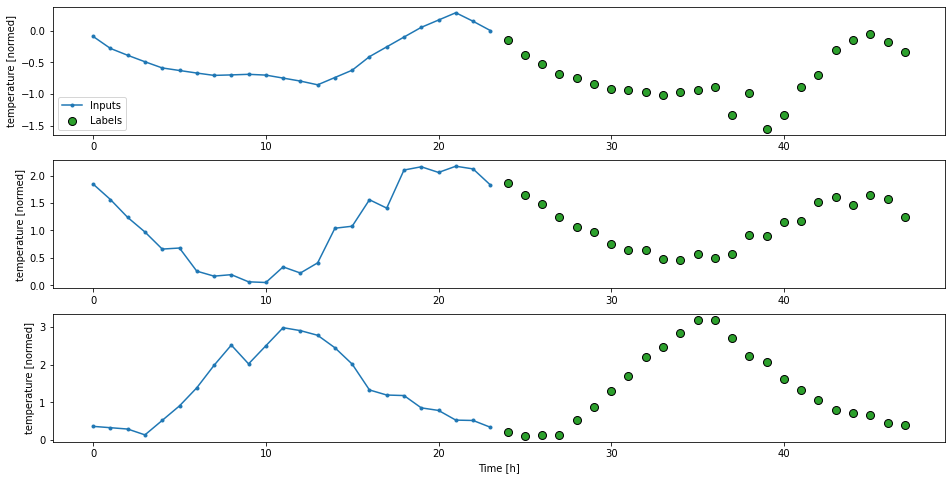

In [2436]:
# Define a window object with parameters to make predictions
# Input width is how many hours used to make prediction and shift says how far to predict
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

421/421 [==============================] - 1s 1ms/step - loss: 0.7447 - mean_absolute_error: 0.5141


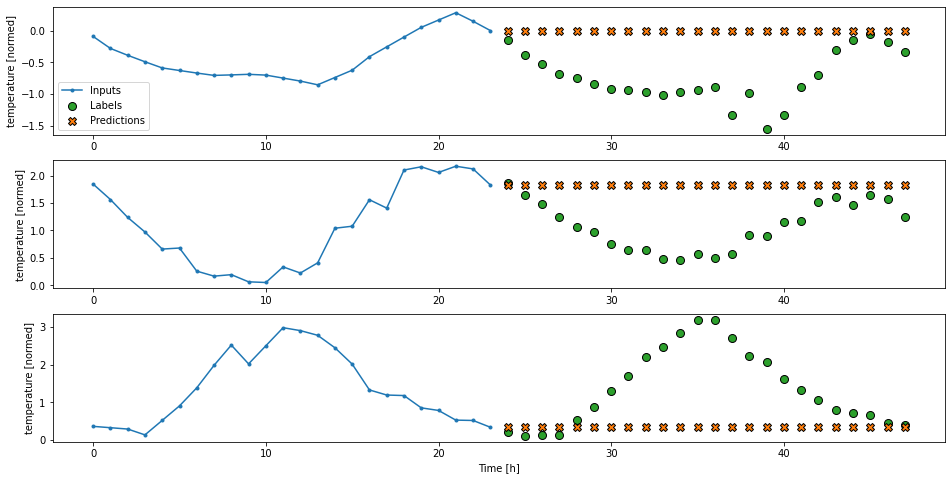

In [2437]:
# A baseline that simply repeats the last timestep for each new predicted timestep
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

# Initialize and compile
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

# Arrays to track performance for end results
multi_val_performance = {}
multi_performance = {}

# Save results and display predictions
multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

421/421 [==============================] - 1s 1ms/step - loss: 0.1515 - mean_absolute_error: 0.1668


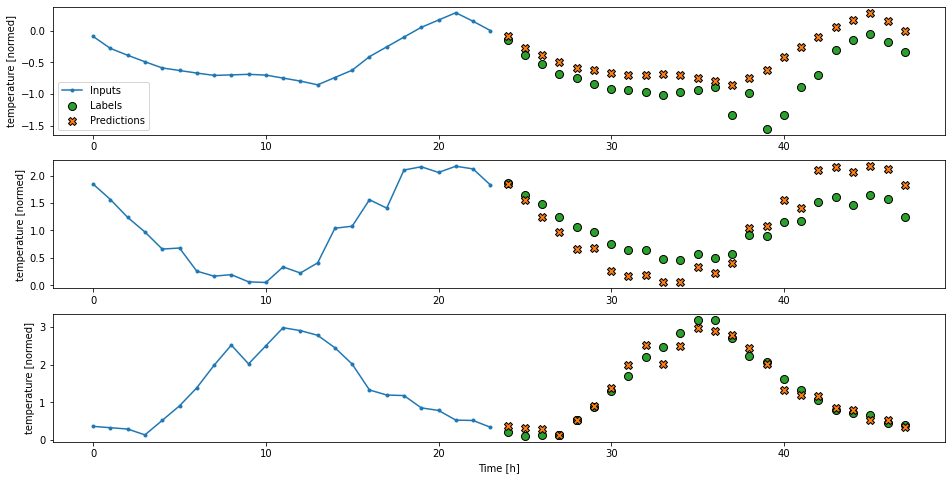

In [2438]:
# Another baseline that simply repeats the previous day as predictions
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
      return inputs

# Initialize and compile
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

# Save results and display predictions
multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

421/421 [==============================] - 1s 1ms/step - loss: 0.2716 - mean_absolute_error: 0.3125


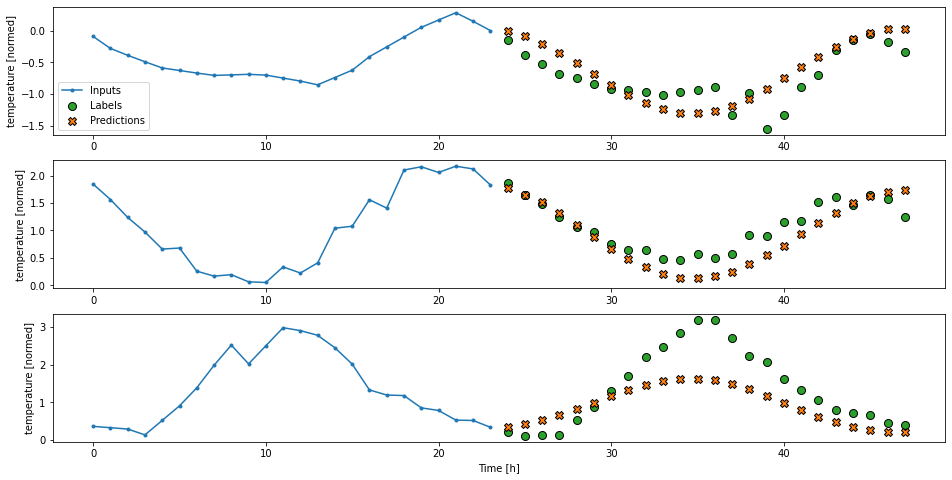

In [2439]:
# Uses last timestep
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    # Get to s shape of [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
# Save results and display predictions
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

421/421 [==============================] - 1s 1ms/step - loss: 0.2525 - mean_absolute_error: 0.2982


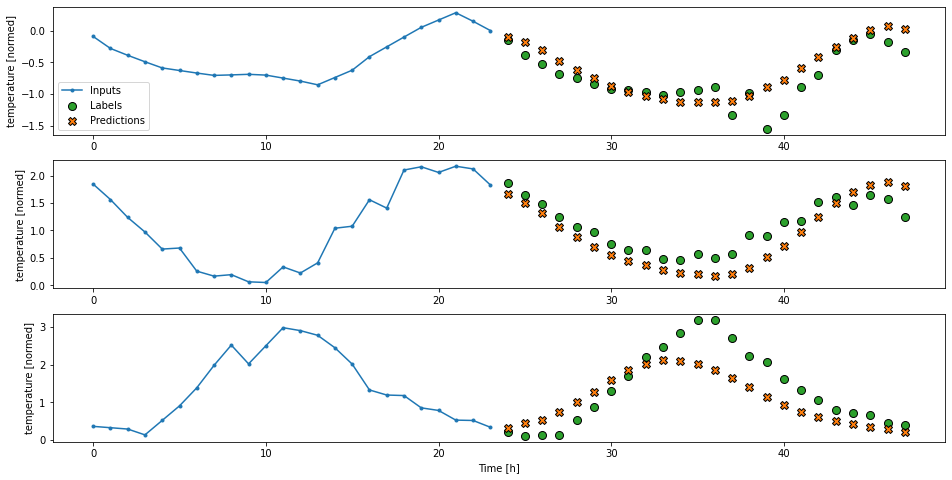

In [2440]:
# Uses last timestep again but adds an extra Dense layer
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    # Again gets to shape [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
# Save results and display predictions
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

421/421 [==============================] - 1s 1ms/step - loss: 0.1054 - mean_absolute_error: 0.1566


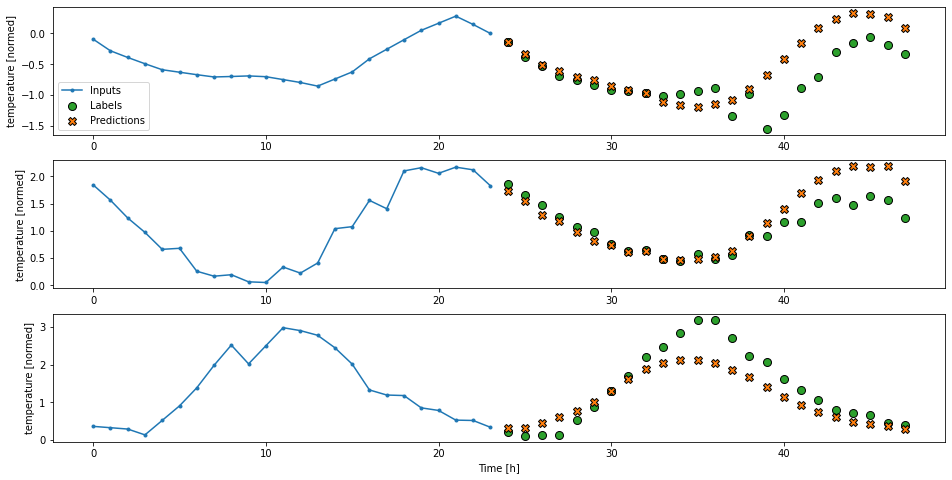

In [2441]:
CONV_WIDTH = 3
# Makes predictions based on fixed width history
multi_conv_model = tf.keras.Sequential([
    # Starts in shape [batch, time, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    # Ends in shape [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()
# Save results and display predictions
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

421/421 [==============================] - 1s 2ms/step - loss: 0.0994 - mean_absolute_error: 0.1594


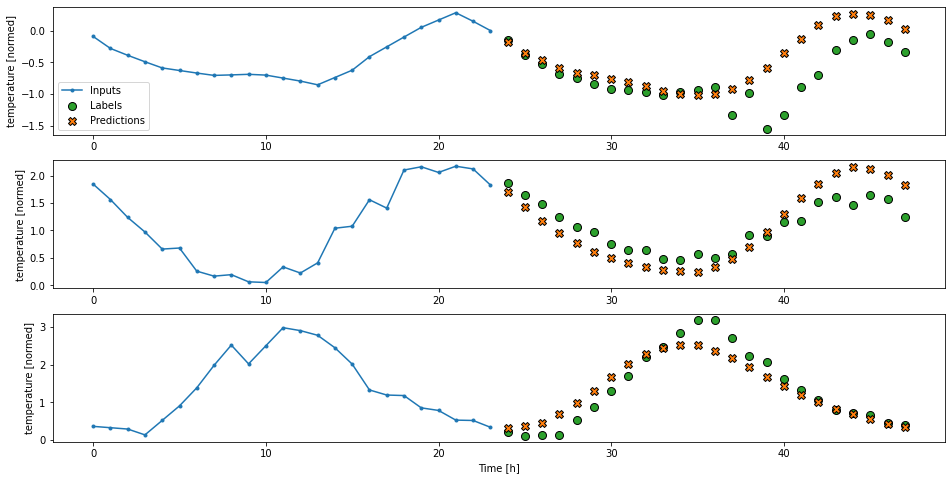

In [2442]:
# Model accumulates internal state for 24h before making first prediction
# Still only produces output at last timestep so return_sequences=false
multi_lstm_model = tf.keras.Sequential([
    # Goes from [batch, time, features] to [batch, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Then to shape [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    # Ends in shape [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()
# Save results and display predictions
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [2443]:
# Used for autoregressive model in which the output is fed back into the model at each step to help make new predictions
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [2444]:
# Initialize
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [2445]:
# Method to initialize internal state based on inputs
def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [2446]:
prediction, state = feedback_model.warmup(multi_window.example[0])

In [2447]:
def call(self, inputs, training=None):
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps using last prediction as input
    for n in range(1, self.out_steps):
        x = prediction
        # Execute one lstm step and convert output to a prediction before then re-adding the prediction to the output
        x, state = self.lstm_cell(x, states=state, training=training)
        prediction = self.dense(x)
        predictions.append(prediction)

    predictions = tf.stack(predictions)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

421/421 [==============================] - 1s 3ms/step - loss: 0.1020 - mean_absolute_error: 0.1671


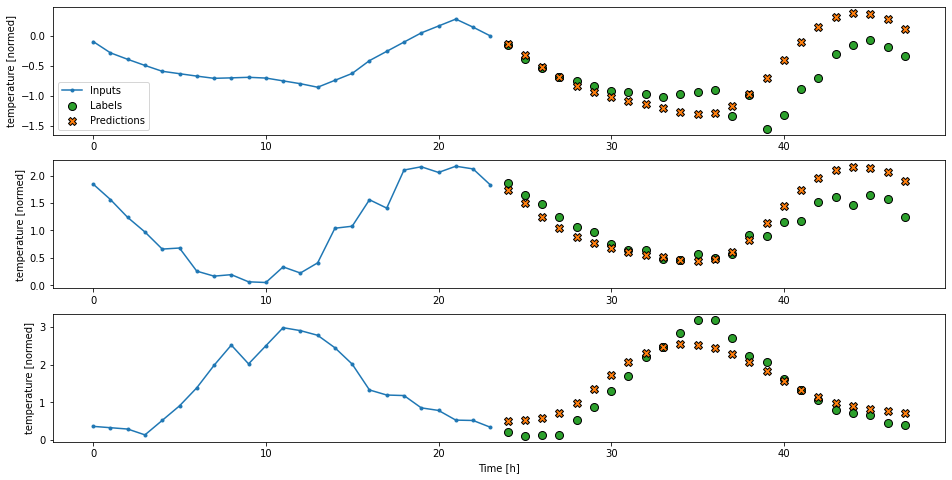

In [2448]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()
# Save results and display predictions
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

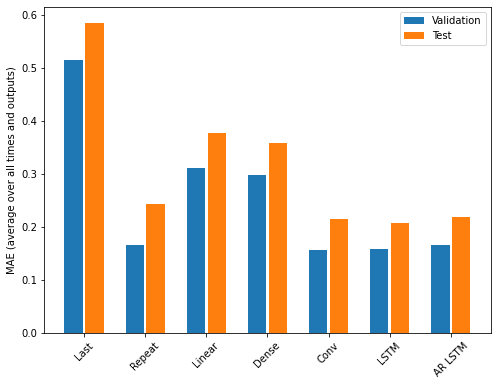

In [2449]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

# Display the MAE (Mean Absolute Error) for both the validation and test sets for each model
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [2450]:
# Print MAE for each model tested
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5863
Repeat  : 0.2435
Linear  : 0.3770
Dense   : 0.3585
Conv    : 0.2159
LSTM    : 0.2083
AR LSTM : 0.2184
